In [1]:
# import utility modules
import pandas as pd
import numpy as np
import configparser
import os


import numpy as np
import pandas as pd
import latex

from scipy.optimize import minimize
from helpers.helper_classes import AddFeatureNames, GeneSPCA, LoadingsSPCA, EnetSPCA
# from helpers.helper_functions import get_data_pev
from joblib import dump, load

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])

In [2]:
# Read config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

os.chdir(config['PATH']['ROOT_DIR'])

# Read data
data = load(config['PATH']['DATA_DIR'] + '/microarray-data-dict.lib')
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

# Read parameters
SEED = config.getint('PARAMS', 'SEED')
N_COMPONENTS = config.getint('PARAMS', 'N_COMPONENTS')

In [7]:
def get_spca(alpha, n_components = 20, n_jobs = 6):
    return EnetSPCA(alpha = alpha, max_iter = 10000, tol = 0.0001, l1_ratio = 0.05, n_components = n_components, n_jobs = 6)


def get_gene_spca(l1, n_components = 20):
    spca_obj = GeneSPCA(max_iter = 10000, tol = 0.0000001, n_components = n_components, alpha = l1)
    return spca_obj

def get_data_pev(X, n_components = 20, verbose = 0, step_size = 0.5, get_transform = get_spca):
    """ 
    Function that returns the explained variance of the first principal component for a single dataset versus 
    the number of non-zero loadings / genes

    Returns:
    - nonzero_columns_arr: array with number of columns with a non-zero influence on the first principal component
    - nonzero_loadings_arr: array with number of non-zero loadings of 'B' matrix
    - PEV_var_arr: array with explained variance of first principal component
    """
    
    # Initialize values for loop
    nz_percentage = 1
    alpha_cur = 0

    # arrays
    nz_loadings = []
    nz_cols = []
    PEV_arr = []

    while nz_percentage > 0.01:

        # Obtain and fit spca object
        spca_cur = get_transform(alpha_cur, n_components = n_components).fit(X)
        X_spca_cur = spca_cur.transform(X)

        # Obtain PEV: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8636462/
        X_recovered_cur = X_spca_cur @ spca_cur.loadings.T
        PEV = 1 -  np.linalg.norm(X_recovered_cur.values - X.values, ord = 'fro') ** 2 / np.linalg.norm(X.values, ord = 'fro') ** 2

        # Count number of nonzero loadings and columns
        nz_percentage_old = nz_percentage
        nz_percentage = spca_cur.nonzero / spca_cur.totloadings
        if nz_percentage - nz_percentage_old < 0.05:
            step_size = step_size * 2
        elif nz_percentage - nz_percentage_old > 0.4:
            step_size = step_size / 2
        
        # Append values to arrays
        zero_rows = sum(np.count_nonzero(spca_cur.loadings[i,:]) == 0 for i in range(spca_cur.loadings.shape[0]))
        nz_cols.append((X.shape[1] - zero_rows) / X.shape[1])
        nz_loadings.append(nz_percentage)
        PEV_arr.append(PEV)

        # Print values when verbose
        if verbose == 1:
            print("regularization = ", alpha_cur)
            print("nonzero columns = ", nz_cols[-1])
            print("nonzero loadings = ", nz_loadings[-1])
            print("PEV = ", PEV)
            print("")

        # Update l1_cur
        alpha_cur += step_size
    
    return nz_cols, nz_loadings, PEV_arr

In [8]:
plot_dir = config['LOGGING']['FIG_DIR'] + '/pev_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# pev_dataset_list = ['golub', 'christensen', 'chin', 'nakayama']
pev_dataset_list = ['christensen', 'khan', 'alon', 'sorlie', 'gravier']
logging_dict = {}
for dname in pev_dataset_list:
    X = data[dname]['none']['X_train']
    
    nz_cols_gspca, nz_loadings_gspca, PEV_arr_gspca = get_data_pev(X, n_components = 20, verbose = 1, step_size = 0.5, get_transform = get_gene_spca)
    nz_cols_spca, nz_loadings_spca, PEV_arr_spca = get_data_pev(X, n_components = 20, verbose = 1, step_size = 0.000001, get_transform = get_spca)
    
    # Plot PEV versus number of non-zero columns
    plt.plot(nz_cols_spca, PEV_arr_spca, label = 'SPCA')
    plt.plot(nz_cols_gspca, PEV_arr_gspca, label = 'Gene-SPCA')
    plt.legend()
    plt.title('PEV of first principal component on ' + dname + ' dataset')
    plt.xlabel('Number of genes with non-zero loadings')
    plt.ylabel('PEV')
    plt.savefig(plot_dir + '/' + dname + '_nzcols_pev.pdf')

    # Plot PEV versus number of non-zero loadings
    # create new plot
    plt.figure()
    plt.plot(nz_loadings_spca, PEV_arr_spca, label = 'SPCA')
    plt.plot(nz_loadings_gspca, PEV_arr_gspca, label = 'Gene-SPCA')
    plt.legend()
    plt.title('PEV of first principal component on ' + dname + ' dataset')
    plt.xlabel('Number of non-zero loadings')
    plt.ylabel('PEV')
    plt.savefig(plot_dir + '/' + dname + '_nzloadings_pev.pdf')
    
    
    logging_dict[dname] = {'spca': {'nz_cols': nz_cols_spca, 'nz_loadings': nz_loadings_spca, 'PEV_arr': PEV_arr_spca}, 'gspca': {'nz_cols': nz_cols_gspca, 'nz_loadings': nz_loadings_gspca, 'PEV_arr': PEV_arr_gspca}}
dump(logging_dict, config['LOGGING']['LOG_DIR'] + '/pev_plots/plot_data.lib')

regularization =  0
nonzero columns =  1.0
nonzero loadings =  1.0
PEV =  0.7452787286504685

regularization =  2e-06
nonzero columns =  1.0
nonzero loadings =  1.0
PEV =  0.04412642154277868

regularization =  6e-06
nonzero columns =  1.0
nonzero loadings =  1.0
PEV =  0.04415428147712852

regularization =  1.4e-05
nonzero columns =  1.0
nonzero loadings =  0.8331140350877193
PEV =  0.1514416282031864

regularization =  2.9999999999999997e-05
nonzero columns =  1.0
nonzero loadings =  0.7425438596491228
PEV =  0.26467433478309954

regularization =  6.199999999999999e-05
nonzero columns =  1.0
nonzero loadings =  0.6811403508771929
PEV =  0.3678308822918467

regularization =  0.00012599999999999997
nonzero columns =  1.0
nonzero loadings =  0.6464912280701754
PEV =  0.46544706132527647



/Users/casparhentenaar/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/VU Master/vu-case-study-eds/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.892e-02, tolerance: 5.511e-02
  model = cd_fast.enet_coordinate_descent(
/Users/casparhentenaar/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/VU Master/vu-case-study-eds/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.567e-02, tolerance: 4.483e-02
  model = cd_fast.enet_coordinate_descent(
/Users/casparhentenaar/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/VU Master/vu-case-

regularization =  0.000254
nonzero columns =  1.0
nonzero loadings =  0.6083333333333333
PEV =  0.5536659002558392



/Users/casparhentenaar/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/VU Master/vu-case-study-eds/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.681e-02, tolerance: 5.511e-02
  model = cd_fast.enet_coordinate_descent(
/Users/casparhentenaar/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/VU Master/vu-case-study-eds/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.080e-02, tolerance: 4.483e-02
  model = cd_fast.enet_coordinate_descent(
/Users/casparhentenaar/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/VU Master/vu-case-

regularization =  0.00051
nonzero columns =  1.0
nonzero loadings =  0.6112938596491229
PEV =  0.6381030823328991



Process SpawnPoolWorker-4192:
Process SpawnPoolWorker-4189:
Process SpawnPoolWorker-4193:
Process SpawnPoolWorker-4191:
Process SpawnPoolWorker-4190:
Process SpawnPoolWorker-4194:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
  File "/Users/casparhentenaar/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/VU Master/vu-case-study-eds/src/helpers/helper_classes.py", line 2, in <module>
    import pand

KeyboardInterrupt: 

In [55]:
dump(logging_dict, config['LOGGING']['LOG_DIR'] + '/pev_plots/plot_data.lib')


['./logs/pev_plots/plot_data.lib']

In [64]:
data

dname_list = []
for dname, _ in data.items():
    dname_list.append(dname)
dname_list

['yeoh',
 'nakayama',
 'golub',
 'khan',
 'west',
 'alon',
 'subramanian',
 'burczynski',
 'chin',
 'borovecki',
 'shipp',
 'tian',
 'gordon',
 'chiaretti',
 'sorlie',
 'chowdary',
 'sun',
 'pomeroy',
 'gravier',
 'su',
 'christensen',
 'singh']

In [23]:
# generate 3 x 3 numpy array


NameError: name 'R' is not defined

Text(0, 0.5, 'PEV')

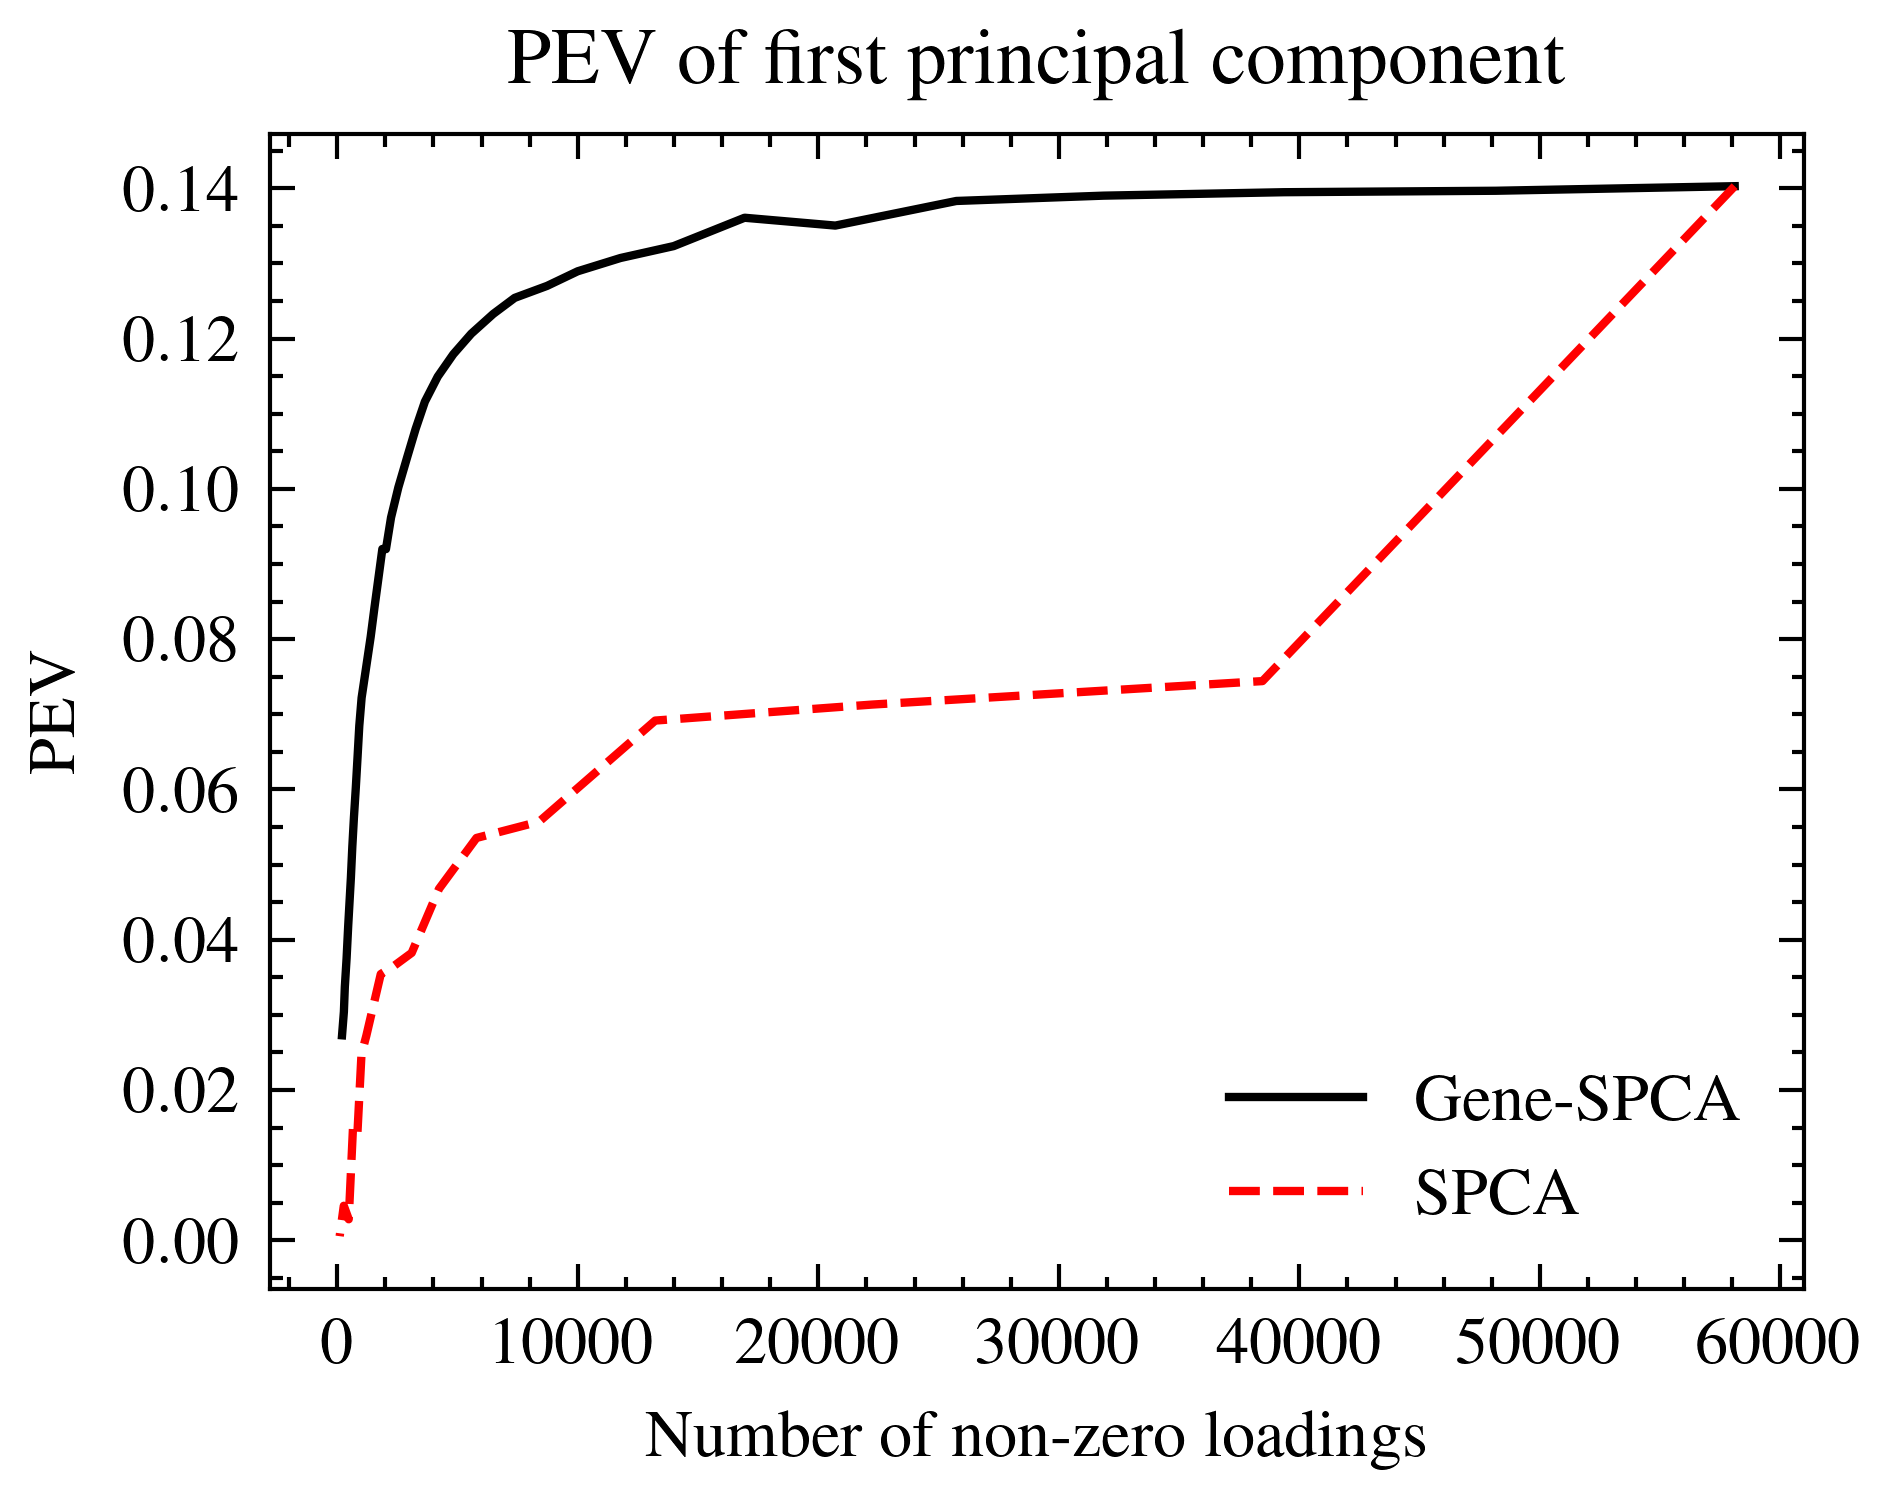

In [39]:
plt.plot(nz_loads, pev_gravier, label = 'Gene-SPCA')
plt.plot(nz_loadss, pev_gravierss, label = 'SPCA')
plt.legend()
plt.title('PEV of first principal component')
plt.xlabel('Number of non-zero loadings')
plt.ylabel('PEV')

In [4]:
X_test = data['christensen']['none']['X_train']
# cov = np.cov(X_test.T)

In [83]:
spca = get_gene_spca(1000, n_components = 20).fit(X_test, verbose = 1)
X_spca = spca.transform(X_test)

  1%|          | 68/10000 [00:01<02:49, 58.67it/s]


In [84]:
X_recovered = X_spca @ spca.loadings.T
X_recovered

,0,1,2,3,4,5,6,7,8,9,...,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
11,0.591795,0.655998,0.409232,-0.361981,-0.197186,0.538104,0.502083,0.158337,0.290107,0.600051,...,-0.193399,-0.181143,0.269491,-0.260528,0.024151,0.127070,0.386155,-0.364330,-0.130965,0.449353
195,0.777901,0.833755,0.631918,-0.607776,-0.331081,0.789943,0.728571,0.265852,0.451134,0.892874,...,-0.324723,-0.327185,0.264720,-0.463841,0.040550,0.370107,0.856416,0.299240,-0.187853,0.671595
35,-0.291859,-0.046663,0.075836,0.100501,0.054747,0.240354,0.253417,-0.043961,0.042903,0.226863,...,0.053696,0.129383,-0.142894,0.062760,-0.006705,-0.340402,-0.435571,-0.554550,0.150086,0.157429
45,-0.018715,-0.054825,-0.074079,0.294802,0.160591,0.095005,0.128530,-0.128952,-0.067370,0.049627,...,0.157507,0.255733,-0.045099,0.236701,-0.019669,-0.116510,-0.359833,-0.188219,0.178269,0.020983
205,0.689447,0.769813,0.531254,-0.539336,-0.293799,0.640290,0.585351,0.235916,0.381107,0.731053,...,-0.288157,-0.302660,0.291943,-0.403589,0.035984,0.221109,0.630174,-0.173803,-0.198987,0.552171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0.000781,-0.107320,0.494064,-0.687054,-0.374267,0.439815,0.366878,0.300530,0.366444,0.551861,...,-0.367079,-0.461822,-0.433290,-0.627364,0.045839,-0.185010,0.424447,0.582743,-0.089762,0.428473
183,0.756983,0.798382,0.578579,-0.560109,-0.305115,0.720216,0.663595,0.245002,0.413290,0.815000,...,-0.299256,-0.303103,0.275079,-0.423086,0.037370,0.332787,0.774497,0.172966,-0.184732,0.613391
198,0.735352,0.780410,0.547657,-0.561663,-0.305962,0.655298,0.597995,0.245682,0.393242,0.749708,...,-0.300086,-0.317522,0.290323,-0.422223,0.037473,0.347394,0.789353,0.173399,-0.205647,0.566653
25,0.511291,0.264981,0.196429,0.365722,0.199224,0.711020,0.757270,-0.159974,0.104298,0.660369,...,0.195398,0.437621,-0.044179,0.295300,-0.024401,0.360634,0.115082,1.112266,0.358012,0.455862


In [85]:
X_test

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x1403,x1404,x1405,x1406,x1407,x1408,x1409,x1410,x1411,x1412
11,0.351061,0.403948,0.290778,-0.033253,0.079453,0.182025,0.129503,-0.054684,-0.210886,0.304597,...,0.006907,-0.313192,0.708630,0.557360,-0.220330,0.614187,0.213489,-0.186192,-0.270281,0.867506
195,0.521128,0.470112,0.568726,-0.449372,-0.114492,0.565915,0.430508,0.136094,0.304700,0.401910,...,-1.059462,-0.811779,0.436954,-0.840415,1.151362,1.102707,0.667728,0.470587,-1.300309,0.803400
35,0.344129,0.181116,0.133460,0.422052,0.012207,0.116815,0.218092,0.241021,0.511729,0.345220,...,0.292355,0.013618,-0.735184,-0.918628,-0.205761,0.445855,-0.521096,-0.061729,2.815289,-0.112643
45,-0.076435,0.456879,0.155308,0.018995,-0.225159,-0.037705,0.159636,-0.220066,-0.379929,0.251564,...,-0.465768,0.247435,-0.195825,-0.576577,0.047281,-0.099089,-0.713939,-0.466711,0.970418,0.145861
205,0.395878,0.479288,0.729274,-0.747000,0.170525,0.393250,0.266338,0.372831,0.239392,0.350968,...,-0.371764,-1.011568,0.905051,0.512624,1.239852,0.836590,0.788486,-0.738614,-0.594939,0.729202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,-0.141092,-1.093771,0.399964,-0.951328,-0.534002,0.450805,0.469698,0.626912,0.922823,0.280562,...,-0.715925,0.359288,-1.452201,-1.050434,-0.073991,-2.116115,-0.118133,0.835358,-0.768742,-0.129857
183,0.422291,0.378835,0.284262,-0.503487,-0.158581,0.603057,0.402844,0.250932,0.569087,0.318834,...,0.199444,-0.235026,0.246522,0.616208,0.491013,0.091100,1.165068,-0.556707,-0.300753,0.902082
198,0.383569,0.454754,0.820774,-0.309422,-0.578091,0.464981,0.266668,-0.027430,-0.234927,0.379051,...,-0.094124,-0.750625,1.167544,-0.091687,1.085585,-0.328351,1.222289,-0.145024,-1.242375,0.772682
25,0.548496,0.638081,0.674298,0.435114,-0.324025,0.715332,0.595007,0.466981,0.454940,0.581386,...,0.146820,1.408457,-0.602440,-0.042748,0.574789,0.128896,0.382179,1.107260,0.194699,0.193941


In [86]:

pev = 1 - np.linalg.norm(X_recovered.values - X_test.values, ord = 'fro') / np.linalg.norm(X_test.values, ord = 'fro')
pev

0.21631029662516343

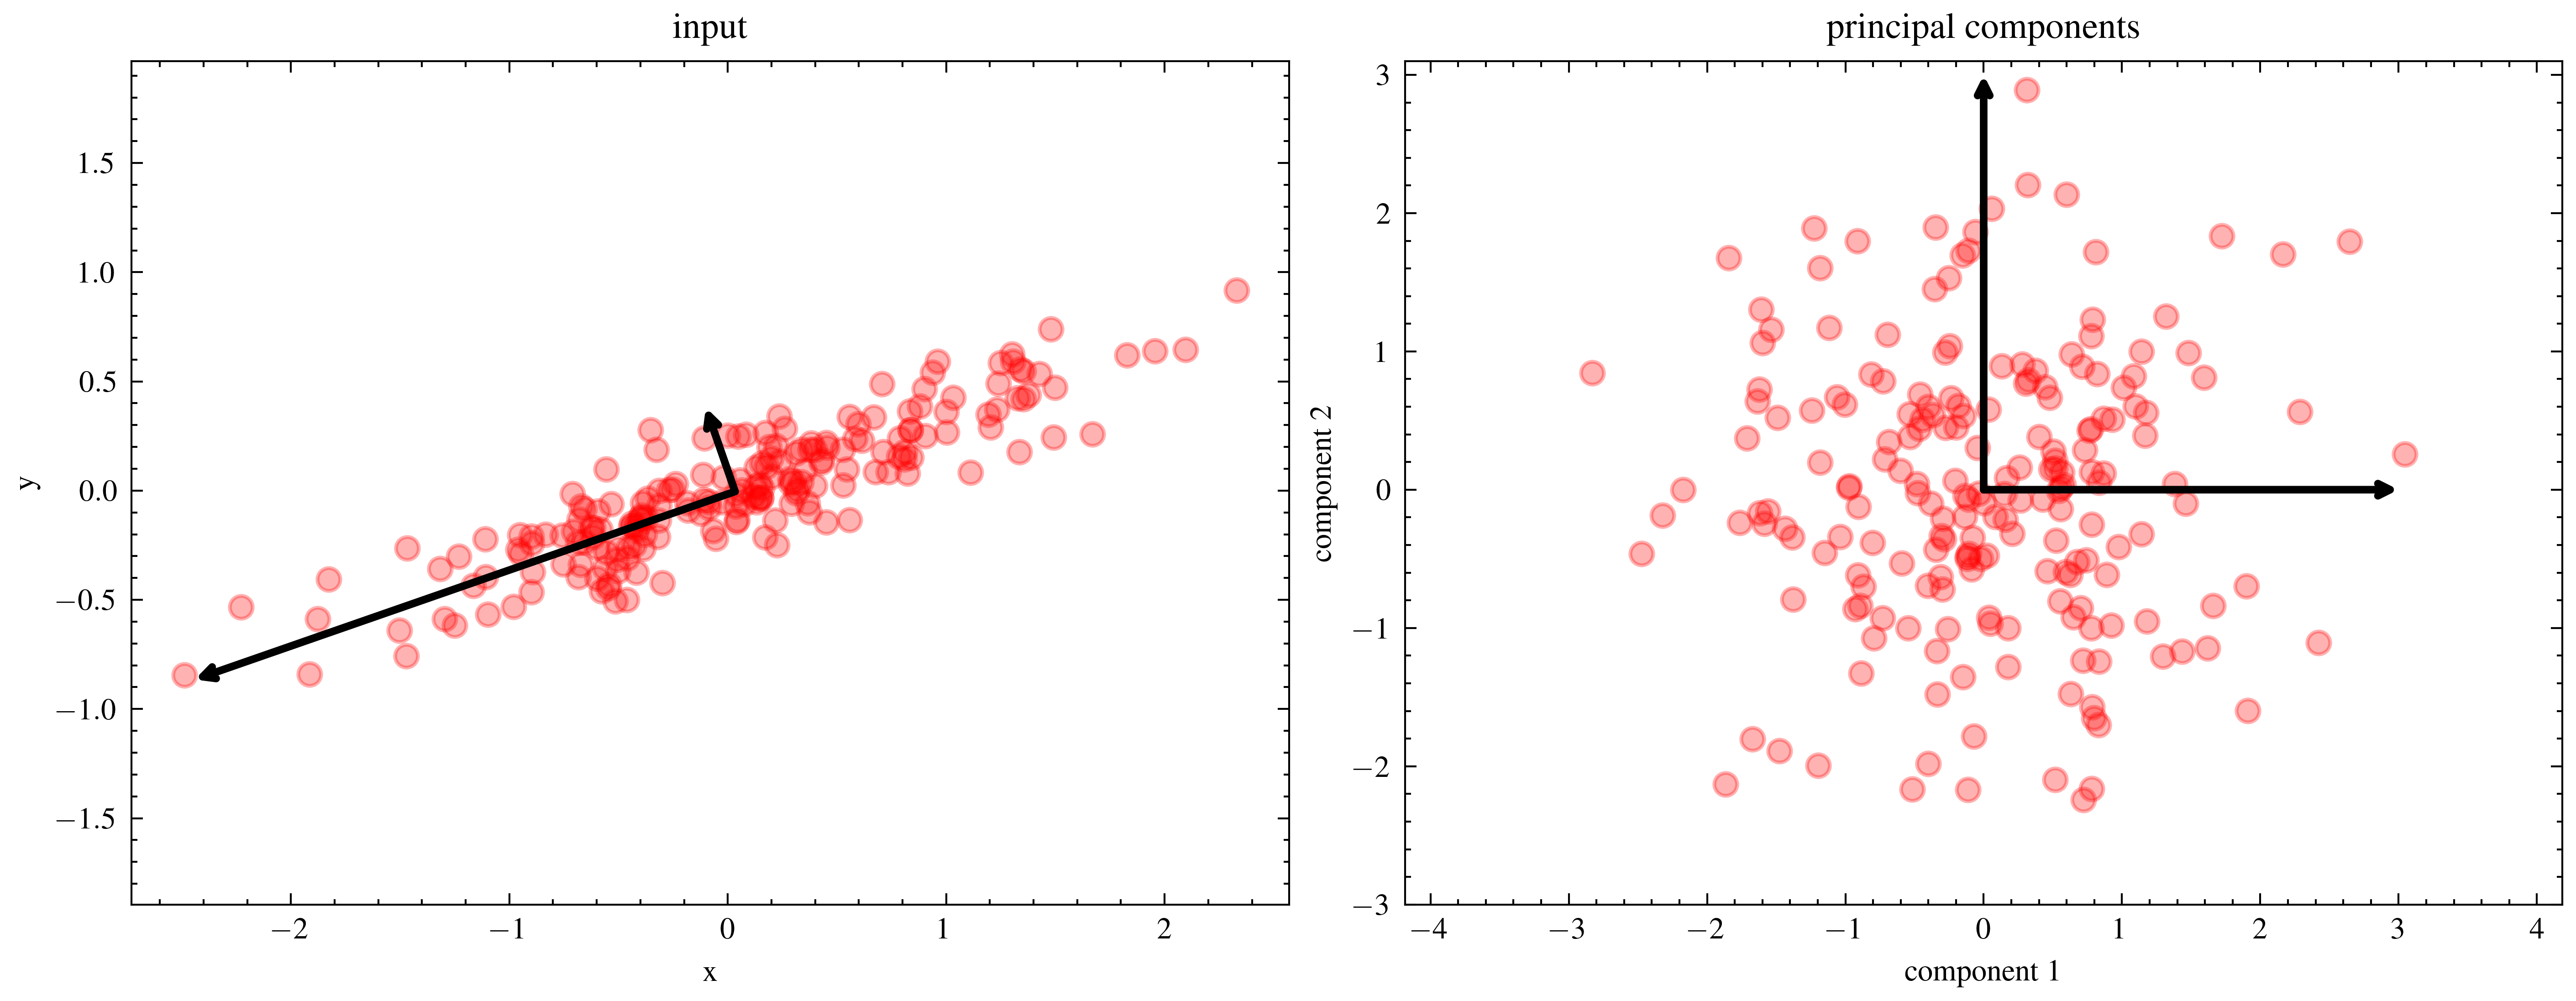

In [12]:
from sklearn.decomposition import PCA

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.3, color='red')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, color = 'red')
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))
plt.savefig('pca.pdf')